In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from theano import ifelse
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers
K.set_image_dim_ordering('th')

Using Theano backend.


In [2]:
# excluded fallen, sand
imgs = {}
labels = {}
src = '/Users/kellyshen/Desktop/229_terrain/'
sets = os.listdir(src)[1:]
for data in sets: # train, val, test
    if data.startswith('.'): continue
    print "on {} set".format(data)
    img_types = os.listdir(src+data+"/")[1:]
    num_classes = len(img_types)
    for label, img_type in enumerate(img_types):
        if img_type.startswith('.'): continue
        print img_type
        for i, img in enumerate(os.listdir(src+data+"/"+img_type+"/")):
            if img.startswith('.'): continue
            if i % 1000 == 0: print i 
            curr = cv2.imread(src+data+"/"+img_type+"/"+img)
            # reshape to be [samples][pixels][width][height]
            b, g, r = curr[:,:,0], curr[:,:,1], curr[:,:,2]
            x = np.stack((r, g, b), axis=0) # reorder to rgb
            # one hot encode labels
            y = np.zeros(num_classes)
            y[label] = 1.0
            if not imgs.get(data):
                imgs[data] = [x]
            else:
                imgs[data].append(x)
            if not labels.get(data):
                labels[data] = [y]
            else:
                labels[data].append(y)

on test set
bark
dirt
0
dry_veg
0
foliage
0
grass
0
paved
0
on train set
bark
dirt
0
1000
dry_veg
0
1000
2000
foliage
0
grass
0
paved
0
1000
on train_aug set
bark
0
1000
2000
3000
4000
5000
dirt
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
dry_veg
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
foliage
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
grass
0
1000
2000
3000
4000
5000
6000
paved
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
on validation set
bark
dirt
0
dry_veg
0
foliage
0
grass
0
paved
0


In [3]:
for set_type, data in imgs.items():
    print(set_type)
    print(np.array(data).shape)
    print(np.array(labels[set_type]).shape)

test
(2408, 3, 100, 100)
(2408, 6)
train_aug
(72150, 3, 100, 100)
(72150, 6)
train
(7215, 3, 100, 100)
(7215, 6)
validation
(2408, 3, 100, 100)
(2408, 6)


In [4]:
X_train = np.array(imgs['train_aug']).astype('float32')/255.0
X_val = np.array(imgs['validation']).astype('float32')/255.0
X_test = np.array(imgs['test']).astype('float32')/255.0
Y_train = np.array(labels['train_aug']).astype('float32')
Y_val = np.array(labels['validation']).astype('float32')
Y_test = np.array(labels['test']).astype('float32')

In [5]:
# for name, data in [('X_train', X_train), ('X_val', X_val), ('X_test', X_test), ('Y_train', Y_train), ('Y_val', Y_val), ('Y_test', Y_test)]:
#     np.save(name +'.npy', data)

In [6]:
# why do we actually need this
# np.random.seed(7)

In [3]:
# The first hidden layer is a convolutional layer called a Convolution2D. 
# The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. 
# This is the input layer, expecting images with the structure outline above [pixels][width][height].

# Next we define a pooling layer that takes the max called MaxPooling2D. 
# It is configured with a pool size of 2×2.

# The next layer is a regularization layer using dropout called Dropout. 
# It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.

# Next is a layer that converts the 2D matrix data to a vector called Flatten. 
# It allows the output to be processed by standard fully connected layers.

# Next a fully connected layer with 128 neurons and rectifier activation function.

# Finally, the output layer has 10 neurons for the 10 classes 
# and a softmax activation function to output probability-like predictions for each class.
# the model is trained using logarithmic loss and the ADAM gradient descent algorithm.

def baseline_model():
    # Create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(3, 100, 100), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def baseline_model2():
    model = Sequential() 
    model.add(Conv2D(20, (5, 5), input_shape=(3, 100, 100), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))  
    model.add(Flatten())
    model.add(Dense(64, activation='relu', activity_regularizer=regularizers.l2(0.02)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

# Convolutional layer with 30 feature maps of size 5×5.
# Pooling layer taking the max over 2*2 patches.
# Convolutional layer with 15 feature maps of size 3×3.
# Pooling layer taking the max over 2*2 patches.
# Dropout layer with a probability of 20%.
# Flatten layer.
# Fully connected layer with 128 neurons and rectifier activation.
# Fully connected layer with 50 neurons and rectifier activation.
# Output layer.

def larger_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def larger_model2():
    model = Sequential()
    model.add(Conv2D(20, (5, 5), input_shape=(3, 100, 100), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(11, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [8]:
model = baseline_model()
# fit over 10 epochs with a batch size of 200.
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=200, verbose=2)
model.save('cnn_base_model') 

Train on 72150 samples, validate on 2408 samples
Epoch 1/10
 - 887s - loss: 1.0066 - acc: 0.6701 - val_loss: 0.3870 - val_acc: 0.8422
Epoch 2/10
 - 952s - loss: 0.4198 - acc: 0.8447 - val_loss: 0.3488 - val_acc: 0.8675
Epoch 3/10
 - 1023s - loss: 0.3183 - acc: 0.8822 - val_loss: 0.2960 - val_acc: 0.8825
Epoch 4/10
 - 1005s - loss: 0.2331 - acc: 0.9158 - val_loss: 0.2888 - val_acc: 0.8816
Epoch 5/10
 - 1008s - loss: 0.1955 - acc: 0.9281 - val_loss: 0.4571 - val_acc: 0.8335
Epoch 6/10
 - 1036s - loss: 0.1465 - acc: 0.9476 - val_loss: 0.3604 - val_acc: 0.8708
Epoch 7/10
 - 1022s - loss: 0.1249 - acc: 0.9559 - val_loss: 0.3647 - val_acc: 0.8800
Epoch 8/10
 - 1039s - loss: 0.1150 - acc: 0.9597 - val_loss: 0.3045 - val_acc: 0.8995
Epoch 9/10
 - 1050s - loss: 0.1073 - acc: 0.9636 - val_loss: 0.3280 - val_acc: 0.8929
Epoch 10/10
 - 1114s - loss: 0.0694 - acc: 0.9770 - val_loss: 0.3831 - val_acc: 0.8862


In [9]:
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 12.46%


In [4]:
# num_classes = 6
model = baseline_model()
# fit over 10 epochs with a batch size of 200.
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=8, batch_size=200, verbose=2)
model.save('cnn_base_model_8epoch')

Train on 72150 samples, validate on 2408 samples
Epoch 1/8
 - 913s - loss: 0.9581 - acc: 0.6695 - val_loss: 0.5926 - val_acc: 0.7757
Epoch 2/8
 - 947s - loss: 0.4838 - acc: 0.8152 - val_loss: 0.3402 - val_acc: 0.8937
Epoch 3/8
 - 1012s - loss: 0.3477 - acc: 0.8719 - val_loss: 0.3319 - val_acc: 0.8617
Epoch 4/8
 - 1029s - loss: 0.2915 - acc: 0.8926 - val_loss: 0.3182 - val_acc: 0.8904
Epoch 5/8
 - 1033s - loss: 0.2240 - acc: 0.9194 - val_loss: 0.2938 - val_acc: 0.8953
Epoch 6/8
 - 1031s - loss: 0.1928 - acc: 0.9299 - val_loss: 0.3160 - val_acc: 0.8837
Epoch 7/8
 - 988s - loss: 0.1681 - acc: 0.9387 - val_loss: 0.3259 - val_acc: 0.8937
Epoch 8/8
 - 988s - loss: 0.1344 - acc: 0.9516 - val_loss: 0.3960 - val_acc: 0.8679


In [5]:
scores = model.evaluate(X_test, Y_test, verbose=2)
print("CNN test error: %.2f%%" % (100-scores[1]*100))

CNN test error: 13.75%


In [2]:
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
X_test = np.load("X_test.npy")
Y_train = np.load("Y_train.npy")
Y_val = np.load("Y_val.npy")
Y_test = np.load("Y_test.npy")
model = keras.models.load_model('cnn_base_model')
model2 = keras.models.load_model('cnn_base_model_8epoch')

In [5]:
print(X_test.shape)
print(X_test[0].shape)

(2408, 3, 100, 100)
(3, 100, 100)


In [9]:
Y_pred_vecs = model.predict(X_test, verbose=1)
# np.save('pred_Ytest_model10', Y_pred_vecs)
print Y_pred_vecs

# Y_pred_vecs_val = model.predict(X_val, verbose=1)
# np.save('pred_Yval_model10', Y_pred_vecs_val)
# Y_pred_vecs_train = model.predict(X_train, verbose=1)
# np.save('pred_Ytrain_model10', Y_pred_vecs_train)

# Y_pred_vecs2 = model2.predict(X_test, verbose=1)
# Y_pred_vecs_val2 = model2.predict(X_val, verbose=1)
# Y_pred_vecs_train2 = model2.predict(X_train, verbose=1)

2408/2408 [==============================] - 14s 6ms/step
[[  9.99928594e-01   2.07283314e-13   1.79017604e-07   5.18237866e-05
    3.69163033e-10   1.93960750e-05]
 [  9.99951065e-01   6.10521165e-17   4.89307095e-05   2.68658932e-11
    2.34709892e-16   1.16191508e-10]
 [  3.35061178e-03   2.49811505e-10   9.96639967e-01   5.89364117e-06
    2.98582721e-11   3.51153608e-06]
 ..., 
 [  2.07315644e-23   2.96233621e-10   2.38877504e-08   5.42675105e-09
    1.94232893e-21   1.00000000e+00]
 [  2.29450547e-09   1.90083469e-08   2.40870810e-04   2.24548991e-10
    7.77911874e-14   9.99759078e-01]
 [  2.49298147e-08   4.68142563e-03   3.21027706e-03   3.14091099e-03
    3.27603288e-07   9.88967061e-01]]


In [12]:
Y_pred_vecs.shape

(2408, 6)

In [47]:
#Y_pred0 = np.apply_along_axis(np.argmax, 1, np.load('pred_Ytest_model.npy'))
# Y_pred = np.apply_along_axis(np.argmax, 1, Y_pred_vecs)
# Y_true = np.apply_along_axis(np.argmax, 1, Y_test)
# print Y_pred.shape
# print Y_true.shape
# print Y_pred0
# print Y_pred
# print Y_true

# Y_pred_val = np.apply_along_axis(np.argmax, 1, Y_pred_vecs_val)
# Y_true_val = np.apply_along_axis(np.argmax, 1, Y_val)
# print Y_pred_val
# Y_pred_train = np.apply_along_axis(np.argmax, 1, Y_pred_vecs_train)
# Y_true_train = np.apply_along_axis(np.argmax, 1, Y_train)

# Y_pred2 = np.apply_along_axis(np.argmax, 1, Y_pred_vecs2)
# Y_pred_val2 = np.apply_along_axis(np.argmax, 1, Y_pred_vecs_val2)
# Y_pred_train2 = np.apply_along_axis(np.argmax, 1, Y_pred_vecs_train2)

[0 0 2 ..., 5 5 5]


In [44]:
from sklearn.metrics import precision_recall_fscore_support
#scores = precision_recall_fscore_support(Y_true, Y_pred)
#scores = precision_recall_fscore_support(Y_true_val, Y_pred_val)
scores = precision_recall_fscore_support(Y_true_train, Y_pred_train)
print scores[0] #precision
print scores[1] #recall
print scores[2] #f1
print scores[3] #support, number of occurrences of each label in y_true

[ 0.99894403  0.95585944  0.99842672  0.99969633  1.          0.9784336 ]
[ 0.99929577  0.98343722  0.97787436  0.99656912  1.          0.99437635]
[ 0.99911987  0.96945225  0.98804367  0.99813027  1.          0.98634056]
[ 5680 11230 25310  9910  6150 13870]


In [51]:
# counts_pred1 = []
# for i in set(Y_pred):
#     counts_pred1.append(np.count_nonzero(Y_pred==i))
# print(counts_pred1)
# Y_pred_enc = np.zeros((len(Y_pred_vecs), 6))
# Y_pred_enc[np.arange(len(Y_pred_vecs)), Y_pred] = 1 
# print Y_pred_enc

# counts_pred = np.apply_along_axis(sum, 0, Y_pred_enc)
# counts = np.apply_along_axis(sum, 0, Y_test)
# print counts_pred
# print counts

# conf = confusion_matrix(Y_true, Y_pred)
# print conf
# conf_val = confusion_matrix(Y_true_val, Y_pred_val)
# print conf_val
# conf_train = confusion_matrix(Y_true_train, Y_pred_train)
# print conf_train
# conf2 = confusion_matrix(Y_true, Y_pred2)
# print conf2
# conf_val2 = confusion_matrix(Y_true_val, Y_pred_val2)
# print conf_val2
# conf_train2 = confusion_matrix(Y_true_train, Y_pred_train2)
# print conf_train2

[  5682.  11554.  24789.   9879.   6150.  14096.]
[  5680.  11230.  25310.   9910.   6150.  13870.]


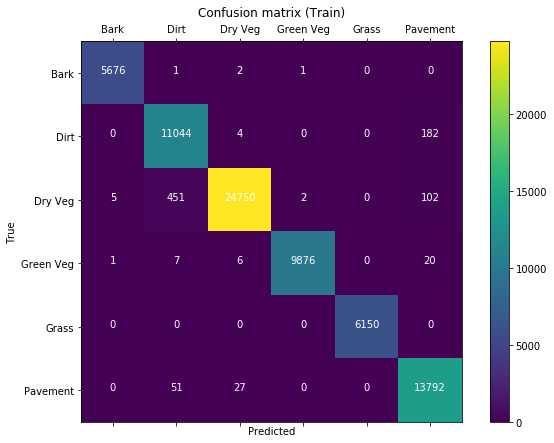

In [32]:
cm = conf_train # change

normalize = False
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
labels=["Bark", "Dirt", "Dry Veg", "Green Veg", "Grass", "Pavement"]
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)
cax = ax.matshow(cm) 
plt.title('Confusion matrix (Train)') # change
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
fmt = '.2f' if normalize else 'd'
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center", color="white")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('conf model10 train') # change
plt.show()